In [1]:
import numpy as np
import gym
import random
import time
from IPython.display import clear_output
import torch
from torch.autograd import Variable
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
env = gym.make("FrozenLake-v0")

In [3]:
action_space_size =  env.action_space.n
state_space_size = env.observation_space.n

print(state_space_size,action_space_size)

16 4


In [4]:
class ReplayMemory:
    #rotating buffer of size N
    def __init__(self,N):
        self.memory = []
        self.size = N
    
    def add(self,experience):
        self.memory.append(experience)
        if(len(self.memory) > self.size):
            del self.memory[0]

#Define what our experience looks like
#[state,action,reward,next_state]

In [5]:
discount = .99 #as is said in the paper

class QNetwork(torch.nn.Module):
    def __init__(self,input_dimension,output_dimension,trainable=True):
        
        super(QNetwork, self).__init__()
        
        self.input_weights = nn.Linear(input_dimension,128)
        self.hidden = nn.Linear(128,32)
        self.output = nn.Linear(32,output_dimension)
        
    def forward(self,x):
        x = x.float()
        y_pred = F.relu(self.input_weights(x))
        y_pred = F.relu(self.hidden(y_pred))
        y_pred = F.softmax(self.output(y_pred))
        return y_pred
        

class Learner:
    def __init__(self,N):
        self.replay = ReplayMemory(N)
        self.QNetwork = QNetwork(16,4)
        self.TargetNetwork = QNetwork(16,4)
        
        self.optimizer = optim.RMSprop(self.QNetwork.parameters())
    
    def run_model(self,x):
        #x = np.array(x)
        x = torch.from_numpy(x)
        y_pred = self.QNetwork.forward(x)
        return y_pred
    
    def run_target_model(self,x):
        #x = np.array(x)
        x = torch.from_numpy(x)
        y_pred = self.TargetNetwork.forward(x)
        return y_pred
    
    
    def target_network_update(self):
        self.TargetNetwork.load_state_dict(self.QNetwork.state_dict())
    
    def to_onehot(self,state):
        state = int(state)
        #onehot the 16 states
        output = np.zeros(16)
        output[state]=1
        return output
    
    def experience_replay(self):
        # look at the replay randomly and train it with
        # the loss function
        # from the paper
        
        #lets start by taking random frames and we will upgrade
        # this to be minibatches soon
        memory = np.array(self.replay.memory)
        #randomize the memory 
        np.random.shuffle(memory)
        for i in range(len(memory)):
            #print(memory[i])
            experience = memory[i]
            
            state,reward,action,next_state = experience
            
            state = self.to_onehot(state)
            next_state = self.to_onehot(next_state)
            reward = int(reward)
            action = int(action)
            
            #print(max(self.run_model(state)))
            loss = reward + discount*max(self.run_model(next_state))
            loss = loss - self.run_model(state)[action]
            loss = -(loss**2)
            self.optimizer.zero_grad()
            loss.backward()

Loss function for each of our experiences
Q is our desision function that is aproximated from our neural
network

<img src='DQN_Loss.png'>

In [6]:
num_episodes = 2500
max_steps_per_episode = 100

learning_rate = 0.1

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.001

In [7]:
learner = Learner(1000)
experience_update_rate = 100
target_network_update_rate = 500
reward_all_episodes =[]

for episode in range(num_episodes):
    
    state = env.reset()
    done = False
    rewards_current_episode = 0
    
    for step in range(max_steps_per_episode):
        #env.render()
        #clear_output()
        
        # Exploration-exploitation trade-off
        uniform_random_variable= random.uniform(0,1)
        if(uniform_random_variable > exploration_rate):
            #if we are exploiting,
            #we use the action that has the highest 
            #value in our q_table at that state
            state_onehot = learner.to_onehot(state)
            action = learner.run_model(state_onehot).max(0)[1]
            action = int(action)
            #print(action)
            
        else:
            #other wise explore randomly
            action = env.action_space.sample()
            
        new_state, reward, done, info = env.step(action)
        
        rewards_current_episode+=reward
        
        
        
        experience = [state,rewards_current_episode,action,new_state]
        learner.replay.add(experience)
        state= new_state
        
        
        if(done):
            break
            
    #Decay the exploration rate after each loop
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    reward_all_episodes.append(rewards_current_episode)
    
    if(episode % experience_update_rate==0):
        #print(episode)
        #update based on replay memory
        learner.experience_replay()
    if(episode % target_network_update_rate == 0):
        learner.target_network_update()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [9]:
import matplotlib.pyplot as plt
#average every 1000 episodes
average =  [sum(reward_all_episodes[1000*k:1000*(k+1)])/1000 for k in range(int(len(reward_all_episodes)/1000))]
print(average)

[0.006, 0.0]


Best 0.0


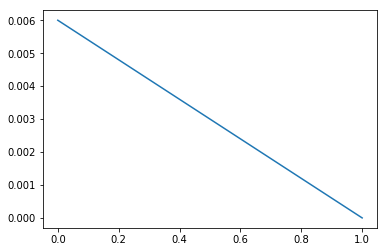

In [10]:
print("Best", average[-1])
plt.plot(average)
plt.show()

In [11]:
#watch it in action

for episode in range(10):
    env.reset()
    print("Episode: %d"%episode)
    
    done = False
    
    for step in range(max_steps_per_episode):
        clear_output(wait=True)
        env.render()
        state = learner.to_onehot(state)
        action = max(learner.run_model(state))
        action = int(action)

        state,reward,done,info = env.step(action)
        if(done):
            break
        time.sleep(.5)

  (Left)
SFFF
FHFH
FFFH
HFFG


KeyboardInterrupt: 